In [1]:
import pandas as pd
import numpy as np

In [2]:
FILE = 'travistorrent_11_1_2017.csv'

In [7]:
dataset = pd.read_csv(FILE, sep=',', engine='c',usecols=['gh_team_size',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'tr_build_id',
                                                         'gh_project_name',
                                                         'gh_is_pr',
                                                         'gh_pr_created_at',
                                                         'gh_lang',
                                                         'git_branch',
                                                         'gh_num_commits_in_push',
                                                         'git_prev_commit_resolution_status',
                                                         'tr_prev_build',
                                                         'gh_first_commit_created_at',
                                                         'gh_team_size',         
                                                         'gh_pushed_at',
                                                         'gh_build_started_at',
                                                         'tr_log_num_tests_ok',        
                                                         'tr_log_num_tests_failed' ,   
                                                         'tr_log_num_tests_skipped'],dtype={ 'tr_build_id': np.float32,
                                                                                            'gh_project_name': 'category',
                                                                                            'gh_is_pr': np.bool,
                                                                                            'gh_pr_created_at': 'category',
                                                                                            'gh_lang': 'category',
                                                                                            'git_branch': 'category',
                                                                                            'gh_num_commits_in_push': np.float32,
                                                                                            'git_prev_commit_resolution_status': 'category',
                                                                                            'tr_prev_build': np.float32,
                                                                                            'gh_first_commit_created_at': 'category',
                                                                                            'gh_team_size': np.int32,
                                                                                            'gh_pushed_at': 'category',
                                                                                            'gh_build_started_at': 'category',
                                                                                            'tr_log_num_tests_ok': np.float32,
                                                                                            'tr_log_num_tests_failed': np.float32,
                                                                                            'tr_log_num_tests_skipped': np.float32}, encoding='utf-8')


In [9]:
dataset

,tr_build_id,gh_project_name,gh_is_pr,gh_pr_created_at,gh_lang,git_branch,gh_num_commits_in_push,git_prev_commit_resolution_status,tr_prev_build,gh_first_commit_created_at,gh_team_size,gh_pushed_at,gh_build_started_at,tr_log_num_tests_ok,tr_log_num_tests_failed,tr_log_num_tests_skipped
0,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
1,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
2,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
3,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
4,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
5,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
6,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
7,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
8,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN
9,106060.0,rails/rails,False,NaN,ruby,3-1-stable,NaN,build_found,105310.0,NaN,240,NaN,2011-08-29 00:25:49,NaN,NaN,NaN


In [6]:
df_ruby = dataset.dropna() # Remove as linhas NAN

df_ruby['date'], df_ruby['hours'] = df_ruby.gh_pushed_at.str.split(' ').str # Separa a coluna que possui data e hora em duas novas colunas de data hora

/home/wagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [8]:
projects = dataset.drop_duplicates(['gh_project_name'])
projects = projects.loc[projects['gh_lang']=='ruby']
projects = projects.gh_project_name


* Taxa de commit por participante no projeto- Quantidade total de commits / Quantidade total de participantes

In [9]:
def rate_commit(projects):
    list_project_name = []
    list_rate_commit = []
    
    for project_name in projects:
        # Define projeto
        df_ruby = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto
        #df_ruby = df_ruby.dropna() # Remove as linhas NaN
        
        # Remove linhas duplicadas
        df_ruby = df_ruby.drop_duplicates(['tr_build_id']) # remove as linhas duplicadas
        start_build = df_ruby['tr_build_id'] # cria uma serie com os ids das builds unicas do projeto
        
        
        # Soma de todos push
        num_commit = df_ruby.gh_num_commits_in_push.sum() 
        
        # Quantidade de contribuidores do projeto
        team_size = int(df_ruby.gh_team_size.head(1))
         

        if((num_commit != 0) and (team_size != 0)):
            # Media projeto
            mean_project = len(start_build)/team_size
            
            # Taxa commit
            taxa_commit = (num_commit/ mean_project)
            
            list_rate_commit.append(taxa_commit)
            list_project_name.append(project_name)
    return(list_rate_commit, list_project_name)

In [10]:
def project_frequency(list_rate_commit, list_project_name):
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    veryHigh_frequenci = []
    
    for i in range(len(list_rate_commit)):
        if(list_rate_commit[i] < 4):
            low_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] < 8) :
            medium_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] < 17):
            high_frequency.append(list_project_name[i])
        
        else:
            veryHigh_frequency.append(list_project_name[i])
            
    return(low_frequency, medium_frequency, high_frequency)

In [11]:
list_rate_commit, list_project_name = rate_commit(projects)

In [85]:
low, medium, high = project_frequency(list_rate_commit, list_project_name)

* Versão apenas coluna de commit

In [35]:
def rate_commit_test(projects):
    list_project_name = []
    list_rate_commit = []
    
    for project_name in projects:
        # Define projeto
        df_ruby = dataset.loc[dataset['gh_project_name'] == project_name] # Filtro penas o projeto
        #df_ruby = df_ruby.dropna() # Remove as linhas NaN
        
        # Remove linhas duplicadas
        df_ruby = df_ruby.drop_duplicates(['tr_build_id']) # remove as linhas duplicadas
        start_build = df_ruby['tr_build_id'] # cria uma serie com os ids das builds unicas do projeto
        
        # Soma de todos push
        num_commit = df_ruby.gh_num_commits_in_push.sum() 
        
        list_rate_commit.append(num_commit)
        list_project_name.append(project_name)
    return(list_rate_commit, list_project_name)

In [38]:
def project_frequency_test(list_rate_commit, list_project_name):
    low_frequency = []
    medium_frequency = []
    high_frequency = []
    veryHigh_frequency = []
    
    for i in range(len(list_rate_commit)):
        if(list_rate_commit[i] <= 207):
            low_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] <= 340):
            medium_frequency.append(list_project_name[i])
            
        elif(list_rate_commit[i] <= 580):
            high_frequency.append(list_project_name[i])
        
        else:
            veryHigh_frequency.append(list_project_name[i])
            
    return(low_frequency, medium_frequency, high_frequency)

In [29]:
list_rate_commit, list_project_name = rate_commit_test(projects)

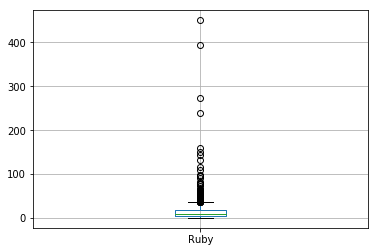

In [43]:
df = pd.DataFrame(list_rate_commit, columns=['Ruby'])

df.boxplot(column=['Ruby'])